In [ ]:
%reset

In [2]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [ ]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds
from astropy import units as u


%matplotlib inline

In [ ]:
grains=1000
num_simulations = 160
sims_already_generated = 320
num_workers = 16

In [ ]:
energy_range = [1_000, 100_000] #MeV 
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2_000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
lat_cut_degrees = 30 #degrees # 0 degrees is full sky
luminosity_range = np.array([1e13, 1e53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.


parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

In [ ]:
# my_cosmology = 'Planck18'
# z_range = [0, 14]

# AEGIS object for Dark matter signal
def build_aegis_object():
    # use this for extragalactic sources
    # engine = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, verbose = False)
    
    engine = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, verbose = False)
    engine.angular_cut_gen, engine.lat_cut_gen = angular_cut_gen, lat_cut_gen
    return engine


In [7]:
# 1) Point to your data directory and choose a channel
data_dir = "/home/users/ids29/DGRB/data/dm_spectra/"         # must contain AtProduction_gammas.dat
channel  = "Tau"                           # e.g. 'b' (bottom quarks) or 'Tau'


# 2) Build the DMsignal object
dm = DMsignal.DMsignal(directory=data_dir, channel=channel)

Dark Matter Model

In [8]:
def DM_abundance(r, L, params): # Outputs the abundance function in the form dN/dV/dL. Note the dV.
    """
    Abundance function for the DM signal.
    """
    # r is the distance from the source # kpc
    # L is the luminosity of the source # photons/second
    # return the abundance function in the form dN/dV/dL in units of 1 / (kpc^3 photon/second)
    # params conatins 'mass of DM particle in GeV'




    A_DM = params[0]
    mass_DM_GeV = params[1] # UPDATE TO THE CURRENT PARAMS INDEX

    LFs = np.zeros_like(L)

    
    beta = 1.9
    A = 1.2e4 # MSolar^{-1} kpc^{-3}
    r_s = 21 #kpc
    r_tilde = r / r_s # unitless # same shape as 'r'
    cross_section = 3e-26 #cm^3 s^{−1}
    
    def compute_integral_E(E_min: float, E_max: float, n_points: int = 10_001) -> float:
        """
        Compute ∫ dN/dE dE between E_min and E_max [MeV]
        by sampling on a uniform grid and applying Simpson's rule.
        n_points must be odd for Simpson's rule.
        """
        # make sure we have an odd number of points
        if n_points % 2 == 0:
            n_points += 1

        E = np.linspace(E_min, E_max, n_points)
        dNdE = dm.get_dNdE(
            desired_E_MeV=E,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )
        return simpson(dNdE, x=E)

    Emin, Emax = energy_range_gen[0], energy_range_gen[1] # MeV
    integral_E = compute_integral_E(Emin, Emax)



    Phi_pp = A_DM * cross_section / (8 * np.pi * mass_DM_GeV**2) * integral_E  # cm^3 s^{-1} GeV^{-2}

    
    def integrand_M_tilde(M_tilde, r, L):
        sigma = 0.74 + 0.011 * np.log(r/50) - 0.003 * M_tilde / 0.87
        Delta = np.log(L) - 77.4 + 0.23*np.log(r/50) - np.log((8*np.pi*Phi_pp)/(1e-28)) # unitless
        mu = sigma**2 * (1-beta) / 0.87  +  Delta
        
        return np.exp((mu**2 - Delta**2)/(2*sigma**2)) * np.exp(-(M_tilde - mu)**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)
    


    # def compute_integral_M_tilde_simpson(M_tilde_min: float, M_tilde_max: float, n_points: int = 10001) -> float:
    #     """
    #     Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
    #     n_points must be odd; if it's even, it's incremented by 1.
    #     """
    #     if n_points % 2 == 0:
    #         n_points += 1
    #     M_tilde = np.linspace(M_tilde_min, M_tilde_max, n_points)
    #     M_tilde_vec = M_tilde[:, None, None]  # add broadcast dims  # (10001, 1, 1)
    #     y = integrand_M_tilde(M_tilde_vec)
    #     print(f"y.shape = {y.shape}, expect shape = {grains-1}, {grains-1}")
    #     return simpson(y, x=M_tilde, axis=0)

    def compute_integral_M_tilde_simpson(M_tilde_min: float, M_tilde_max: float, r, L, n_points: int = 10001) -> float:
        """
        Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
        n_points must be odd; if it's even, it's incremented by 1.
        """
        if n_points % 2 == 0:
            n_points += 1
        M_tildes = np.linspace(M_tilde_min, M_tilde_max, n_points)
        y = integrand_M_tilde(M_tildes, r, L)
        return simpson(y, x=M_tildes)


    # Example usage:
    M_min = 1 # MSolar
    M_tilde_min = 0.87 * np.log(M_min/1e5) # M_min = 1 MSolar

    for i in range(LFs.shape[0]):
        for j in range(LFs.shape[1]):
            integral_M_tilde = compute_integral_M_tilde_simpson(M_tilde_min, 14.0, r[i,j], L[i,j]) # The integrand 'integrand_M_tilde' is sufficiently suppressed for all M_tilde > 14.0
            LFs[i,j] = 10**(5*(1-beta)) * A / (0.87 * L[i,j] * r_tilde[i,j] * (1+r_tilde[i,j])**2)   * integral_M_tilde # units of 1 / (kpc^3 photon/second)
    
    
    # print(f"integral_M_tilde_quad / integral_M_tilde_simpson = {integral_M_tilde_quad / integral_M_tilde}")
    
    
    # print(f"LFs.shape = {LFs.shape}")
    return LFs
    # return 10**(5*(1-beta)) * A / (0.87 * L * r_tilde * (1+r_tilde)**2)   * integral_M_tilde_quad # units of 1 / (kpc^3 photon/second)


def DM_abundance_wrapper(x, L, params): # this function needs to be passed to AEGIS
     
    r = np.sqrt(x**2 + 8.5**2 - 2 * 8.5 * x * np.cos(np.deg2rad(40))) # x is the ad-hoc distance from the center of the Milky Way in kpc, and 8.5 is the distance of the Sun from the center of the Milky Way in kpc

    # Returns the abundance function in the form dN/dR/dL. Note the dR.
    # return 4*np.pi*r**2 * DM_abundance(r, L, params) # dV = 4*np.pi*r^2 dr, so we need to multiply by 4*np.pi*r^2

    # Returns the abundance function in the form dN/dV/dL. Note the dV.
    return DM_abundance(r, L, params)

def DM_spectrum(energy, params): #'energy' is an array of energies in MeV 
    mass_DM_GeV = params[1] # UPDATE TO THE CURRENT PARAMS INDEX
    return dm.get_dNdE(
            desired_E_MeV=energy,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )

# AEGIS functions for Dark matter signal
als_DM = [DM_abundance_wrapper, DM_spectrum]

Background signal

In [9]:
# Add Fermi isotropic background source class
data_root = '/home/users/ids29/DGRB'
my_FB = FermiBackgrounds.FermiBackgrounds(data_root)
def spec_iso_wrap(energy, params):
    A_BG = params[0]
    iso_fit = my_FB.get_isotropic_background_spectrum_func()
    correction_normalization = 397_174 / 351_854 # this factor adjusts the normalization such that the number of photons in this faux isotropic background is equal to the sum of number of photons in the Fermi isotropic background,
                               # and the number of photons in the Fermi non-isotropic background, everthing measured in the region of interest defined by the angular cut and latitudinal cut.
    return A_BG * iso_fit(energy) * correction_normalization

# AEGIS functions for Fermi isotropic background
als_FIB = [spec_iso_wrap]

In [10]:
# a simple simulator with the total number of photons as the summary statistic
def simulator(my_AEGIS, params):

    input_params = params.numpy()

    source_info = my_AEGIS.create_sources(input_params, grains=grains, epsilon=1e-2)
    photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info, grains=grains) 
    obs_info = {'psf_fits_path': '/home/users/ids29/DGRB/FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '/home/users/ids29/DGRB/FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)
    
    return obs_photon_info

Generate Training Data

In [ ]:
def manual_simulate_for_sbi(proposal, num_simulations=1000, num_workers=32):
    """
    Simulates the model in parallel using joblib.
    Each simulation call samples a parameter from the proposal and passes the index to the simulator.
    """
    def run_simulation(i):
        if i % 10 == 0:
            print(f"i= {i}")

        # torch.set_num_threads(1)
        # torch.set_num_interop_threads(1)
        
        # Sample a parameter from the proposal (sbi.utils.BoxUniform has a .sample() method
        theta_i = proposal.sample()
        params_DM, params_BG = theta_i[[0,2]], theta_i[[1]]

        # Instatantiate the AEGIS object for DM and Background
        obj_AEGIS = build_aegis_object()

        # Configure the AEGIS object for DM
        obj_AEGIS.abun_lum_spec = [als_DM]
        obj_AEGIS.source_class_list = ['isotropic_faint_single_spectrum']

        # Run the simulator for DM data
        photon_info_DM = simulator(obj_AEGIS, params_DM)

        # Configure the AEGIS object for Background
        obj_AEGIS.abun_lum_spec =  [als_FIB] 
        obj_AEGIS.source_class_list = ['isotropic_diffuse']

        # Run the simulator for Background data
        photon_info_BG = simulator(obj_AEGIS, params_BG)

        # Save the photon information and theta parameters to files.
        with open(f'train_data_DM_bohr_{i + sims_already_generated}.pkl', 'wb') as f:
            pickle.dump(photon_info_DM, f)
        with open(f'train_data_BG_bohr_{i + sims_already_generated}.pkl', 'wb') as f:
            pickle.dump(photon_info_BG, f)

        torch.save(params_DM, f'train_thetas_DM_bohr_{i + sims_already_generated}.pt')
        torch.save(params_BG, f'train_thetas_BG_bohr_{i + sims_already_generated}.pt')

        # # atomically write once per job
        # torch.save({'data_DM': photon_info_DM, 'data_BG': photon_info_BG,
        #             'θ_DM': params_DM, 'θ_BG': params_BG},
        #         f'kerr_data/job_{i:05}.pt')


    # Run simulations in parallel using joblib.
    # Switch to the threading backend
    with parallel_backend('threading', n_jobs=num_workers):
        Parallel(timeout=None)(delayed(run_simulation)(i) for i in range(num_simulations))

In [ ]:
# Define the prior using sbi.utils.BoxUniform
A_DM_training_range = [100, 500]
A_BG_training_range = [0.8, 1.1]
M_chi_training_range = [150, 350] # mass of DM particle in GeV

prior_range = torch.tensor([[A_DM_training_range[0], A_BG_training_range[0],  M_chi_training_range[0]],
                            [A_DM_training_range[1], A_BG_training_range[1], M_chi_training_range[1]]])

prior = utils.BoxUniform(low=prior_range[0], high=prior_range[1])
print(f"low = {prior_range[0]}, high = {prior_range[1]}")

manual_simulate_for_sbi(prior, num_simulations=num_simulations, num_workers=num_workers)

Load Test parameters

In [ ]:
# # ────────────────────────────────────────────────────────────────────────
# # 3)  Ask the object for its default model parameters
# #     (mass, amplitude, background).  These numbers come straight from
# #     the get_default_model() method you showed.
# # ────────────────────────────────────────────────────────────────────────
# model_defaults = dm.get_default_model()        # {'A_DM': …, 'A_BG': …, 'mass_DM_MeV': …}
# mass_DM_MeV_test    = model_defaults["mass_DM_MeV"]  # MeV
# mass_DM_GeV_test    = mass_DM_MeV_test / 1e3                  # GeV
# A_DM_test           = model_defaults["A_DM"] # unitless
# A_BG_test           = model_defaults["A_BG"]

# print(f"A_DM_test = {A_DM_test}; mass_DM_GeV_test = {mass_DM_GeV_test}; A_BG_test = {A_BG_test}")






A_DM_test = 200.0; mass_DM_GeV_test = 200.0; A_BG_test = 1.0


Generate Test Data

Both DM and Background singals

In [ ]:
# params_DM_test = torch.tensor([A_DM_test, mass_DM_GeV_test])
# params_BG_test = torch.tensor([A_BG_test])

# # Instatantiate the AEGIS object for DM and Background
# obj_AEGIS = build_aegis_object()

# # Configure the AEGIS object for DM
# obj_AEGIS.abun_lum_spec = [als_DM]
# obj_AEGIS.source_class_list = ['isotropic_faint_single_spectrum']

# # Run the simulator for DM data
# photon_info_DM_test = simulator(obj_AEGIS, params_DM_test)

# # Configure the AEGIS object for Background
# obj_AEGIS.abun_lum_spec =  [als_FIB] 
# obj_AEGIS.source_class_list = ['isotropic_diffuse']

# # Run the simulator for Background data
# photon_info_BG_test = simulator(obj_AEGIS, params_BG_test)

# # # Save the photon information and theta parameters to files.
# # with open(f'test_data_DM.pkl', 'wb') as f:
# #     pickle.dump(photon_info_DM_test, f)
# # with open(f'test_data_BG.pkl', 'wb') as f:
# #     pickle.dump(photon_info_BG_test, f)

# # torch.save(params_DM_test, f'test_thetas_DM.pt')
# # torch.save(params_BG_test, f'test_thetas_BG.pt')

Only Background signal

In [15]:
# # Instatantiate the AEGIS object
# obj_AEGIS = build_aegis_object()

# # Configure the AEGIS object for Background
# obj_AEGIS.abun_lum_spec =  [als_FIB] 
# obj_AEGIS.source_class_list = ['isotropic_diffuse']

# # Run the simulator for Background data
# params_BG = torch.tensor([A_BG_test])
# photon_info = simulator(obj_AEGIS, params_BG)

Only DM signal

In [16]:
# # Instatantiate the AEGIS object
# obj_AEGIS = build_aegis_object()

# # Configure the AEGIS object for DM subhalos
# obj_AEGIS.abun_lum_spec =  [als_DM]
# obj_AEGIS.source_class_list = ['isotropic_faint_single_spectrum']

# # Run the simulator for Background data
# params_DM = torch.tensor([A_DM_test, mass_DM_GeV_test])
# photon_info = simulator(obj_AEGIS, params_DM)

Combine DM and Background data

In [ ]:
# print(f"photon_info_DM_test['energies'].shape = {photon_info_DM_test['energies'].shape}")
# print(f"photon_info_DM_test['angles'].shape = {photon_info_DM_test['angles'].shape}")
# print(f"photon_info_BG_test['energies'].shape = {photon_info_BG_test['energies'].shape}")
# print(f"photon_info_BG_test['angles'].shape = {photon_info_BG_test['angles'].shape}")

photon_info_DM_test['energies'].shape = (25540,)
photon_info_DM_test['angles'].shape = (25540, 2)
photon_info_BG_test['energies'].shape = (198845,)
photon_info_BG_test['angles'].shape = (198845, 2)


In [ ]:
# # Combine dictionaries of DM and Background photon information
# photon_info = {
#     'energies': np.concatenate(
#         (photon_info_DM_test['energies'],
#          photon_info_BG_test['energies'])
#     ),  # axis=0 by default
#     'angles': np.concatenate(
#         (photon_info_DM_test['angles'],
#          photon_info_BG_test['angles']),
#         axis=0
#     )
# }

# print(f"photon_info_combined['energies'].shape = {photon_info['energies'].shape}")
# print(f"photon_info_combined['angles'].shape = {photon_info['angles'].shape}")

photon_info_combined['energies'].shape = (224385,)
photon_info_combined['angles'].shape = (224385, 2)


Generate Sky map

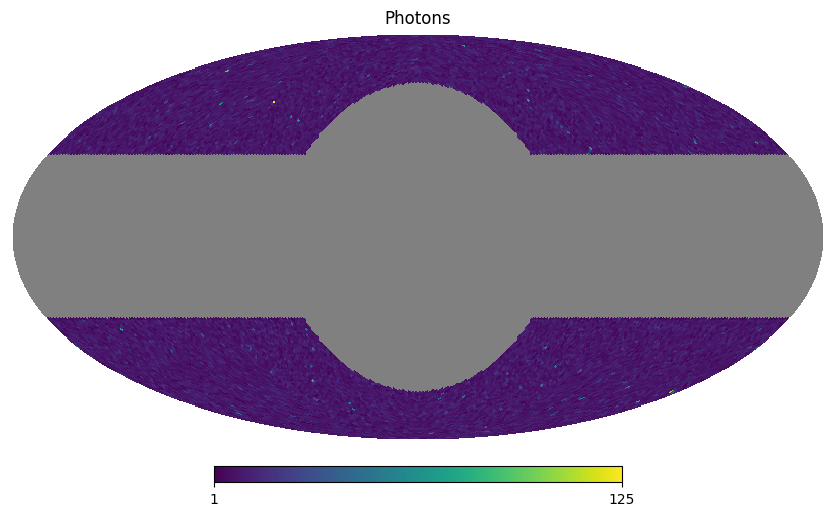

Number of photons in region of interest = 183831


In [ ]:
# center_mask = 60 #deg
# lat_mask = 30 #deg
# # N_Ebins = 10
# # Ebinspace = 'linear'
# # N_countbins = 10
# # countbinspace = 'linear'
# # mincount, maxcount = 0, 60

# N_side = 64
# N_pix = 12*N_side**2
# pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
# roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

# # Generate a heatmap of the photons
# heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
# masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), heatmap[0], hp.UNSEEN)
# hp.mollview(masked_map, title = 'Photons')
# plt.show()

# # Compute number of photons in region of interest
# photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
# roi_mask = np.isin(photon_pixels, roi_pix_i)
# energies_in_roi = photon_info['energies'][roi_mask]
# print(f"Number of photons in region of interest = {energies_in_roi.size}")